In [2]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
#from keras.utils import to_categorical


In [3]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277 entries, 411 to 1126
Data columns (total 3 columns):
filename    1277 non-null object
label       1277 non-null object
offset      1277 non-null float64
dtypes: float64(1), object(2)
memory usage: 39.9+ KB


In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1021
Test: 256


./set_b\murmur__281_1311165683454_B.wav
./set_b\normal_noisynormal_140_1306519735121_C.wav


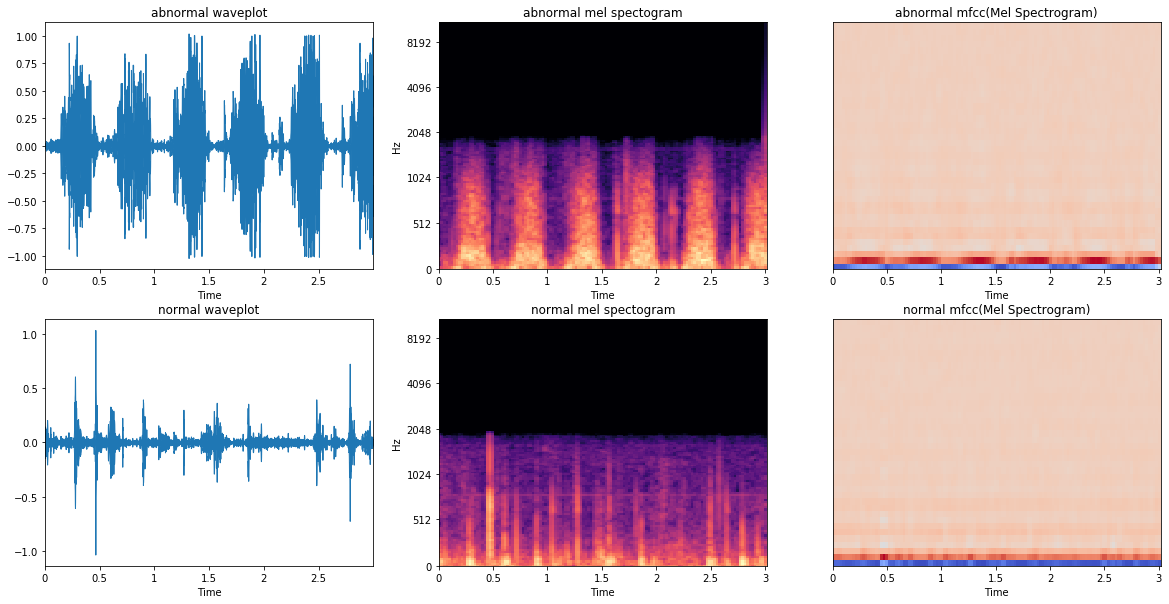

In [5]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

In [6]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [7]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:20<00:00, 12.60it/s]


X train: (1021, 40, 130)
X test: (256, 40, 130)


In [8]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [13]:
from keras.utils.np_utils import to_categorical
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1021, 40, 130, 1)
Y train: (1021, 2)
X test: (256, 40, 130, 1)
Y test: (256, 2)


In [14]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 30, 64)         8

In [23]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [41]:

history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test))

Epoch 1/300
8/8 [==============================] - ETA: 1s - loss: 0.3661 - accuracy: 0.82 - ETA: 1s - loss: 0.3991 - accuracy: 0.83 - ETA: 1s - loss: 0.3897 - accuracy: 0.82 - ETA: 0s - loss: 0.3793 - accuracy: 0.83 - ETA: 0s - loss: 0.3736 - accuracy: 0.83 - ETA: 0s - loss: 0.3895 - accuracy: 0.83 - ETA: 0s - loss: 0.3936 - accuracy: 0.82 - ETA: 0s - loss: 0.3889 - accuracy: 0.82 - 2s 259ms/step - loss: 0.3889 - accuracy: 0.8266 - val_loss: 0.3919 - val_accuracy: 0.8047
Epoch 2/300
8/8 [==============================] - ETA: 1s - loss: 0.4595 - accuracy: 0.77 - ETA: 1s - loss: 0.4285 - accuracy: 0.80 - ETA: 1s - loss: 0.4102 - accuracy: 0.81 - ETA: 0s - loss: 0.3977 - accuracy: 0.82 - ETA: 0s - loss: 0.3868 - accuracy: 0.82 - ETA: 0s - loss: 0.3866 - accuracy: 0.82 - ETA: 0s - loss: 0.3779 - accuracy: 0.82 - ETA: 0s - loss: 0.3847 - accuracy: 0.82 - 2s 253ms/step - loss: 0.3847 - accuracy: 0.8276 - val_loss: 0.3945 - val_accuracy: 0.8203
Epoch 3/300
8/8 [=============================

Text(0.5, 1.0, 'Accuracy Curves')

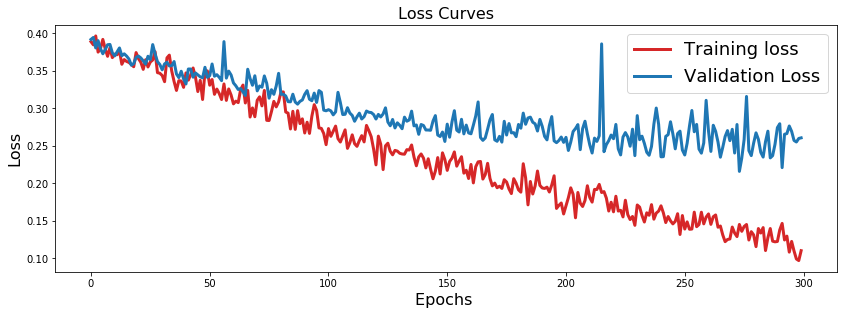

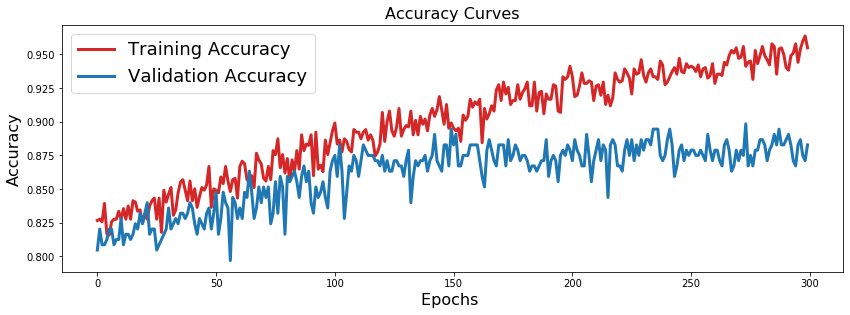

In [42]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [57]:
print("Evaluate on test data")
scores = model.evaluate(x_test, y_test,batch_size=128)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Evaluate on test data
2/2 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.90 - ETA: 0s - loss: 0.2605 - accuracy: 0.88 - 0s 63ms/step - loss: 0.2605 - accuracy: 0.8828
Test loss: 0.26054325699806213
Test accuracy: 0.8828125


In [59]:
print("Generate predictions for samples")
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

Generate predictions for samples
8/8 [==============================] - ETA:  - ETA:  - 0s 15ms/step
              precision    recall  f1-score   support

    abnormal       0.77      0.93      0.84        87
      normal       0.96      0.86      0.91       169

    accuracy                           0.88       256
   macro avg       0.87      0.89      0.88       256
weighted avg       0.90      0.88      0.89       256



In [45]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)